In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

In [3]:
merge_data=pd.read_pickle('merge_regression_data.pkl')
merge_data

,time_id,book.seconds_in_bucket.count,book.wap1.nanmean,book.wap1.nanstd,book.wap1.difference,book.wap2.nanmean,book.wap2.nanstd,book.wap2.difference,book.log_return1.nansum,book.log_return1.realized_volatility_x,book.log_return2.nansum,book.log_return2.realized_volatility,book.log_return_ask1.nansum,book.log_return_ask1.realized_volatility,book.log_return_ask2.nansum,book.log_return_ask2.realized_volatility,book.log_return_bid1.nansum,book.log_return_bid1.realized_volatility,book.log_return_bid2.nansum,book.log_return_bid2.realized_volatility,book.wap_balance.nanmean,book.wap_balance.nanstd,book.BidAskSpread.nanmax,book.BidAskSpread.nanmean,book.BidAskSpread.difference,book.bid_spread.nanmax,book.bid_spread.nanmean,book.bid_spread.difference,book.ask_spread.nanmax,book.ask_spread.nanmean,book.ask_spread.difference,book.total_volume.nansum,book.total_volume.nanmean,book.total_volume.difference,book.volume_imbalance.nansum,book.volume_imbalance.nanmean,book.volume_imbalance.nanmax,missing_values,book_2.5to_9.seconds_in_bucket.count,book_2.5to_9.wap1.nanmean,book_2.5to_9.wap1.nanstd,book_2.5to_9.wap1.difference,book_2.5to_9.wap2.nanmean,book_2.5to_9.wap2.nanstd,book_2.5to_9.wap2.difference,book_2.5to_9.log_return1.nansum,book_2.5to_9.log_return1.realized_volatility,book_2.5to_9.log_return2.nansum,book_2.5to_9.log_return2.realized_volatility,book_2.5to_9.log_return_ask1.nansum,book_2.5to_9.log_return_ask1.realized_volatility,book_2.5to_9.log_return_ask2.nansum,book_2.5to_9.log_return_ask2.realized_volatility,book_2.5to_9.log_return_bid1.nansum,book_2.5to_9.log_return_bid1.realized_volatility,book_2.5to_9.log_return_bid2.nansum,book_2.5to_9.log_return_bid2.realized_volatility,book_2.5to_9.wap_balance.nanmean,book_2.5to_9.wap_balance.nanstd,book_2.5to_9.BidAskSpread.nanmax,book_2.5to_9.BidAskSpread.nanmean,book_2.5to_9.BidAskSpread.difference,book_2.5to_9.bid_spread.nanmax,book_2.5to_9.bid_spread.nanmean,book_2.5to_9.bid_spread.difference,book_2.5to_9.ask_spread.nanmax,book_2.5to_9.ask_spread.nanmean,book_2.5to_9.ask_spread.difference,book_2.5to_9.total_volume.nansum,book_2.5to_9.total_volume.nanmean,book_2.5to_9.total_volume.difference,book_2.5to_9.volume_imbalance.nansum,book_2.5to_9.volume_imbalance.nanmean,book_2.5to_9.volume_imbalance.nanmax,book_5.0to_9.seconds_in_bucket.count,book_5.0to_9.wap1.nanmean,book_5.0to_9.wap1.nanstd,book_5.0to_9.wap1.difference,book_5.0to_9.wap2.nanmean,book_5.0to_9.wap2.nanstd,book_5.0to_9.wap2.difference,book_5.0to_9.log_return1.nansum,book_5.0to_9.log_return1.realized_volatility,book_5.0to_9.log_return2.nansum,book_5.0to_9.log_return2.realized_volatility,book_5.0to_9.log_return_ask1.nansum,book_5.0to_9.log_return_ask1.realized_volatility,book_5.0to_9.log_return_ask2.nansum,book_5.0to_9.log_return_ask2.realized_volatility,book_5.0to_9.log_return_bid1.nansum,book_5.0to_9.log_return_bid1.realized_volatility,book_5.0to_9.log_return_bid2.nansum,book_5.0to_9.log_return_bid2.realized_volatility,book_5.0to_9.wap_balance.nanmean,book_5.0to_9.wap_balance.nanstd,book_5.0to_9.BidAskSpread.nanmax,book_5.0to_9.BidAskSpread.nanmean,book_5.0to_9.BidAskSpread.difference,book_5.0to_9.bid_spread.nanmax,book_5.0to_9.bid_spread.nanmean,book_5.0to_9.bid_spread.difference,book_5.0to_9.ask_spread.nanmax,book_5.0to_9.ask_spread.nanmean,book_5.0to_9.ask_spread.difference,book_5.0to_9.total_volume.nansum,book_5.0to_9.total_volume.nanmean,book_5.0to_9.total_volume.difference,book_5.0to_9.volume_imbalance.nansum,book_5.0to_9.volume_imbalance.nanmean,book_5.0to_9.volume_imbalance.nanmax,book_7.5to_9.seconds_in_bucket.count,book_7.5to_9.wap1.nanmean,book_7.5to_9.wap1.nanstd,book_7.5to_9.wap1.difference,book_7.5to_9.wap2.nanmean,book_7.5to_9.wap2.nanstd,book_7.5to_9.wap2.difference,book_7.5to_9.log_return1.nansum,book_7.5to_9.log_return1.realized_volatility,book_7.5to_9.log_return2.nansum,book_7.5to_9.log_return2.realized_volatility,book_7.5to_9.log_return_ask1.nansum,book_7.5to_9.log_return_ask1.realized_volatility,book_7.5to

In [4]:
non_features=["time_id","stock_id","target"]

In [5]:
features=[col for col in merge_data.columns if col not in non_features]
data=merge_data.dropna(subset=["target"])
features

['book.seconds_in_bucket.count',
 'book.wap1.nanmean',
 'book.wap1.nanstd',
 'book.wap1.difference',
 'book.wap2.nanmean',
 'book.wap2.nanstd',
 'book.wap2.difference',
 'book.log_return1.nansum',
 'book.log_return1.realized_volatility_x',
 'book.log_return2.nansum',
 'book.log_return2.realized_volatility',
 'book.log_return_ask1.nansum',
 'book.log_return_ask1.realized_volatility',
 'book.log_return_ask2.nansum',
 'book.log_return_ask2.realized_volatility',
 'book.log_return_bid1.nansum',
 'book.log_return_bid1.realized_volatility',
 'book.log_return_bid2.nansum',
 'book.log_return_bid2.realized_volatility',
 'book.wap_balance.nanmean',
 'book.wap_balance.nanstd',
 'book.BidAskSpread.nanmax',
 'book.BidAskSpread.nanmean',
 'book.BidAskSpread.difference',
 'book.bid_spread.nanmax',
 'book.bid_spread.nanmean',
 'book.bid_spread.difference',
 'book.ask_spread.nanmax',
 'book.ask_spread.nanmean',
 'book.ask_spread.difference',
 'book.total_volume.nansum',
 'book.total_volume.nanmean',
 'b

In [6]:
def smape(y_true, y_pred):
    """
    Calculate Symmetric Mean Absolute Percentage Error (sMAPE) between true and predicted values.

    Arguments:
    y_true -- Array-like, true values
    y_pred -- Array-like, predicted values

    Returns:
    sMAPE -- Symmetric Mean Absolute Percentage Error
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    return 100 * diff

In [7]:
data.time_id.max()

32767

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from tqdm import tqdm
results_rf=pd.DataFrame()
for stock_id in tqdm(data.stock_id.unique()):
    stock_data = data[data["stock_id"]==stock_id]
    X = stock_data.drop("target",axis=1)
    X = X.fillna(X.mean())
    y = stock_data["target"]

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        

        model = RandomForestRegressor(n_estimators=50,random_state=42,n_jobs=-1,max_features="sqrt")
        model.fit(X_train[features], y_train)

        test_pred = model.predict(X_test[features])

        smape_array = smape(y_test, test_pred)

        fold_results = pd.DataFrame({
            'stock_id': X_test["stock_id"],
            "time_id": X_test["time_id"],
            'RF_SMAPE': smape_array
        })
        results_rf = pd.concat([results_rf, fold_results], ignore_index=True)

100%|██████████| 112/112 [04:33<00:00,  2.44s/it]


In [32]:
results_rf

,stock_id,time_id,RF_SMAPE
0,0,5,10.540688
1,0,147,105.672799
2,0,157,30.816877
3,0,207,1.936181
4,0,256,57.298034
...,...,...,...
428849,126,32680,109.752325
428850,126,32686,33.236511
428851,126,32690,110.261383
428852,126,32692,44.584885


In [34]:
results_rf.mean()

stock_id       62.440271
time_id     16039.047268
RF_SMAPE       29.315779
dtype: float64

In [11]:
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [13]:
import lightgbm as lgb
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from tqdm import tqdm 
from joblib import Parallel, delayed


def train_predict(stock_id, data, features, params):
    stock_data = data[data["stock_id"] == stock_id]
    X = stock_data.drop("target", axis=1)
    X = X.fillna(X.mean())
    y = stock_data["target"]
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    results_lgb = pd.DataFrame()
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        weight_val = 1 / (np.power(y_train, 2) + 1e-5)
        train_data = lgb.Dataset(X_train[features], label=y_train, weight=weight_val)
        test_data = lgb.Dataset(X_test[features], label=y_test)
        
        model = lgb.train(params, train_data, num_boost_round=1500, valid_sets=[test_data])
        
        test_pred = model.predict(X_test[features])
        
        smape_array = smape(y_test, test_pred)
        
        fold_results = pd.DataFrame({
            'stock_id': X_test["stock_id"],
            "time_id": X_test["time_id"],
            'LGB_SMAPE': smape_array
        })
        results_lgb = pd.concat([results_lgb, fold_results], ignore_index=True)
    
    return results_lgb

# Define parameters for LightGBM
params = {
    'objective': 'regression',
    'learning_rate': 0.01,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    "verbose": -1
}

results = Parallel(n_jobs=-1, verbose=10)(delayed(train_predict)(stock_id, data, features, params) for stock_id in tqdm(data.stock_id.unique()))
results_lgb = pd.concat(results, ignore_index=True)


 36%|███▌      | 40/112 [00:56<01:58,  1.65s/it] [Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.9min
 71%|███████▏  | 80/112 [02:52<01:20,  2.50s/it][Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:  3.3min
100%|██████████| 112/112 [03:51<00:00,  2.06s/it]
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  85 out of 112 | elapsed:  5.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  97 out of 112 | elapsed:  5.4min remaining:   50.3s
[Parallel(n_jobs=-1)]: Done 109 out of 112 | elapsed:  5.9min remaining:    9.7s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  6.0min finished


In [14]:
results_lgb.mean()

stock_id        62.440271
time_id      16039.047268
LGB_SMAPE       29.355608
dtype: float64

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

results_lr = pd.DataFrame()
for stock_id in data.stock_id.unique():
    stock_data = data[data["stock_id"]==stock_id]
    X = stock_data.drop("target",axis=1)
    X = X.fillna(X.mean())
    y = stock_data["target"]

    kf = KFold(n_splits=5, shuffle=True, random_state=42)


    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model = LinearRegression()
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=0.95))
        ])
        X_train_pca=pipeline.fit_transform(X_train[features])
        X_test_pca=pipeline.transform(X_test[features])
        model.fit(X_train_pca, y_train)


        test_pred = model.predict(X_test_pca)

        smape_array = smape(y_test, test_pred)

        fold_results = pd.DataFrame({
            'stock_id': X_test["stock_id"],
            "time_id": X_test["time_id"],
            'LR_SMAPE': smape_array
        })
        results_lr = pd.concat([results_lr, fold_results], ignore_index=True)




0
1
2
3
4
5
6
7
8
9
10
11
13
14
15
16
17
18
19
20
21
22
23
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
46
47
48
50
51
52
53
55
56
58
59
60
61
62
63
64
66
67
68
69
70
72
73
74
75
76
77
78
80
81
82
83
84
85
86
87
88
89
90
93
94
95
96
97
98
99
100
101
102
103
104
105
107
108
109
110
111
112
113
114
115
116
118
119
120
122
123
124
125
126


In [16]:
results_lr.mean()

stock_id       62.440271
time_id     16039.047268
LR_SMAPE       29.775580
dtype: float64

In [17]:
results_lr

,stock_id,time_id,LR_SMAPE
0,0,5,12.899735
1,0,147,98.283794
2,0,157,23.424231
3,0,207,11.249827
4,0,256,57.010966
...,...,...,...
428849,126,32680,98.324214
428850,126,32686,30.241786
428851,126,32690,101.162453
428852,126,32692,48.202048


In [35]:
performance_table = results_lr.merge(results_rf, on=['stock_id', 'time_id'])
performance_table = performance_table.merge(results_lgb, on=['stock_id', 'time_id'])
performance_table

,stock_id,time_id,LR_SMAPE,RF_SMAPE,LGB_SMAPE
0,0,5,12.899735,10.540688,11.514050
1,0,147,98.283794,105.672799,84.642098
2,0,157,23.424231,30.816877,29.142489
3,0,207,11.249827,1.936181,8.360764
4,0,256,57.010966,57.298034,66.433129
...,...,...,...,...,...
428849,126,32680,98.324214,109.752325,90.326131
428850,126,32686,30.241786,33.236511,8.419196
428851,126,32690,101.162453,110.261383,104.332435
428852,126,32692,48.202048,44.584885,47.245107


In [36]:
performance_table.sort_values(["stock_id","time_id"])

,stock_id,time_id,LR_SMAPE,RF_SMAPE,LGB_SMAPE
0,0,5,12.899735,10.540688,11.514050
3063,0,11,33.654015,69.384723,49.614546
1532,0,16,99.144909,81.522299,84.873387
2298,0,31,29.962603,27.836634,11.254558
3064,0,62,56.485850,69.431754,73.779680
...,...,...,...,...,...
427320,126,32751,13.276665,16.497378,31.984591
427321,126,32753,83.111193,82.895903,93.236932
425790,126,32758,1.666130,1.806531,46.089555
427322,126,32763,58.089380,46.223397,51.152453


In [37]:
performance_table.to_csv("regression_model_performance.csv")

In [38]:
performance_table.mean()

stock_id        62.440271
time_id      16039.047268
LR_SMAPE        29.775580
RF_SMAPE        29.315779
LGB_SMAPE       29.355608
dtype: float64

In [39]:
df_GARCH = pd.read_csv('./GARCH_SMAPE.csv')

In [40]:
df_GARCH["stock_id"]=df_GARCH['ID'].str.split("-").str[0].astype(np.int64)
df_GARCH["time_id"]=df_GARCH['ID'].str.split("-").str[1].astype(np.int64)
df_GARCH=df_GARCH.drop("ID",axis=1)
df_GARCH

,SMAPE,stock_id,time_id
0,11.147702,0,5
1,85.959453,0,11
2,144.025408,0,16
3,8.677742,0,31
4,28.177509,0,62
...,...,...,...
428680,9.998040,126,32751
428681,22.980743,126,32753
428682,42.947001,126,32758
428683,57.281968,126,32763


In [41]:
df_GARCH = df_GARCH.rename(columns={'SMAPE': 'GARCH_SMAPE'})
performance_table = performance_table.merge(df_GARCH, on=['stock_id', 'time_id'], how='inner')
performance_table

,stock_id,time_id,LR_SMAPE,RF_SMAPE,LGB_SMAPE,GARCH_SMAPE
0,0,5,12.899735,10.540688,11.514050,11.147702
1,0,147,98.283794,105.672799,84.642098,113.945095
2,0,157,23.424231,30.816877,29.142489,45.336740
3,0,207,11.249827,1.936181,8.360764,2.238382
4,0,256,57.010966,57.298034,66.433129,70.160634
...,...,...,...,...,...,...
428680,126,32680,98.324214,109.752325,90.326131,91.760740
428681,126,32686,30.241786,33.236511,8.419196,13.039119
428682,126,32690,101.162453,110.261383,104.332435,116.399763
428683,126,32692,48.202048,44.584885,47.245107,56.219433


In [42]:
performance_table.mean()

stock_id          62.442409
time_id        16039.210567
LR_SMAPE          29.708473
RF_SMAPE          29.248490
LGB_SMAPE         29.288335
GARCH_SMAPE       33.189618
dtype: float64

In [43]:
arima_performance=pd.read_csv("arima_performance.csv")[["stock_id","time_id","ARIMA_SMAPE"]]
arima_performance

,stock_id,time_id,ARIMA_SMAPE
0,0,103,110.111952
1,0,146,116.651557
2,0,250,156.619212
3,0,297,80.654379
4,0,319,70.668581
...,...,...,...
428849,126,32646,122.586417
428850,126,32653,52.557229
428851,126,32724,58.908977
428852,126,32746,38.819924


In [44]:
performance_table=performance_table.merge(arima_performance,on=["stock_id","time_id"],how="inner")
performance_table

,stock_id,time_id,LR_SMAPE,RF_SMAPE,LGB_SMAPE,GARCH_SMAPE,ARIMA_SMAPE
0,0,5,12.899735,10.540688,11.514050,11.147702,57.032624
1,0,147,98.283794,105.672799,84.642098,113.945095,101.069251
2,0,157,23.424231,30.816877,29.142489,45.336740,55.535855
3,0,207,11.249827,1.936181,8.360764,2.238382,36.688524
4,0,256,57.010966,57.298034,66.433129,70.160634,62.297122
...,...,...,...,...,...,...,...
428680,126,32680,98.324214,109.752325,90.326131,91.760740,122.097509
428681,126,32686,30.241786,33.236511,8.419196,13.039119,78.396492
428682,126,32690,101.162453,110.261383,104.332435,116.399763,152.598250
428683,126,32692,48.202048,44.584885,47.245107,56.219433,70.009314


In [45]:
performance_table.sort_values(["stock_id","time_id"],inplace=True)

performance_table.to_csv("performance_table.csv")

In [46]:
performance_table.mean()

stock_id          62.442409
time_id        16039.210567
LR_SMAPE          29.708473
RF_SMAPE          29.248490
LGB_SMAPE         29.288335
GARCH_SMAPE       33.189618
ARIMA_SMAPE       58.434181
dtype: float64

In [49]:
aggregate_dict={"LR_SMAPE":[np.mean],"RF_SMAPE":[np.mean],"LGB_SMAPE":[np.mean],"GARCH_SMAPE":[np.mean]}

In [52]:
stock_id_performance=performance_table.groupby("stock_id").agg(aggregate_dict)

(LR_SMAPE, mean)  (RF_SMAPE, mean)  (LGB_SMAPE, mean)  (GARCH_SMAPE, mean)
15.025848         15.308779         15.264237          16.755202              1
16.733280         16.898776         16.965684          18.494889              1
34.660144         33.803464         34.217121          37.557805              1
33.846037         33.483754         33.716529          39.140913              1
33.178504         33.116743         32.773814          37.826677              1
                                                                             ..
24.761472         24.858635         24.986693          28.111971              1
24.524741         24.068980         24.153867          27.162184              1
24.440072         23.893486         23.965334          27.072613              1
24.238116         24.329795         24.387847          27.332700              1
55.148957         55.410529         55.014991          62.878591              1
Name: count, Length: 112, dtype: int64

In [ ]:
time_id_performance=performance_table.groupby("time_id").agg(aggregate_dict)

<Axes: >

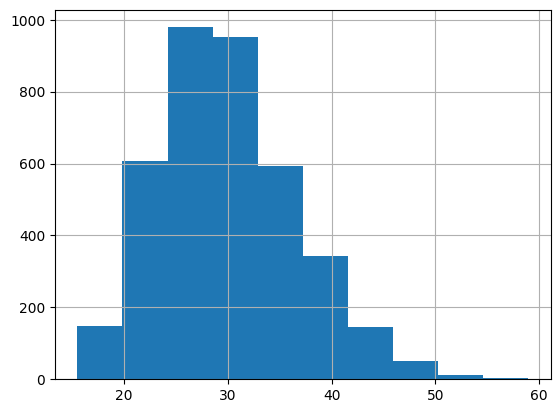

In [ ]:
time_id_performance.mean(axis=1).sort_values().hist()

<Axes: >

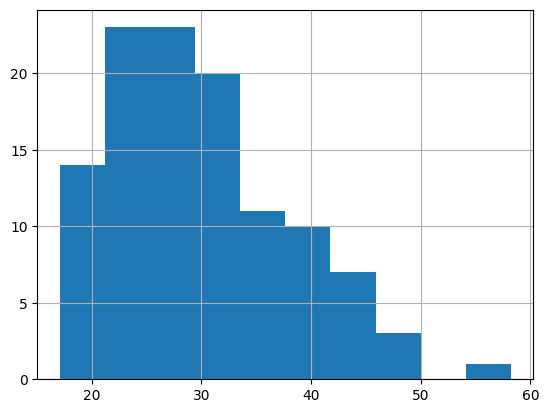

In [ ]:
stock_id_performance.mean(axis=1).sort_values().hist()

In [ ]:
pd.read_csv("performance_table.csv").groupby(["stock_id"])["LR_SMAPE"].mean()

stock_id
0      41.056745
1      26.496137
2      23.230376
3      29.081545
4      36.969094
         ...    
122    25.726124
123    22.805568
124    17.383616
125    29.699115
126    32.407487
Name: LR_SMAPE, Length: 112, dtype: float64